# Transfer Learning with fast.ai

## Classify 7 different diagnosis of pigmented skin lesions.

### Training set: 10015 images of skin 

https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [1]:
from fastai import *
from fastai.vision import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from os import listdir
from os.path import isfile, join
from PIL import Image
%matplotlib inline

### Path to images

In [2]:
path = Path('/home/jupyter/.fastai/data/skincancer/')

## Metadata on images

In [3]:
metadata = pd.read_csv(path/"HAM10000_metadata.csv")

In [4]:
metadata.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp


#### Column "dx" is the label: diagnosis for the patient. There are 7 types:

- akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease 

- bcc:  basal cell carcinoma

- bkl: benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)

- df: dermatofibroma

- mel: melanoma

- nv:  melanocytic nevi

- vasc: vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)


#### Column "dx_type" is the method by which the diagnosis was made. There are 4 types:

- histo: histopathology

- follow_up: follow-up examination

- consensus: expert consensus

- confocal: confirmation by in-vivo confocal microscopy

#### A same lession could have multiple images.




In [26]:
lesion_ids = set(metadata.lesion_id)
n_lesion = len(lesion_ids)
print(n_lesion, 'different lesions')

7470 different lesions


In [6]:
print('Counts by diagnosis:')
metadata.groupby('dx')[['lesion_id', 'image_id']].nunique()

Counts by diagnosis:


,lesion_id,image_id
dx,,
akiec,228,327
bcc,327,514
bkl,727,1099
df,73,115
mel,614,1113
nv,5403,6705
vasc,98,142


In [7]:
print('Counts by method:')
metadata.groupby('dx_type')[['lesion_id', 'image_id']].nunique()

Counts by method:


,lesion_id,image_id
dx_type,,
confocal,34,69
consensus,647,902
follow_up,3704,3704
histo,3085,5340


In [9]:
print('Counts by sex:')
metadata.groupby('sex')[['lesion_id', 'image_id']].nunique()

Counts by sex:


,lesion_id,image_id
sex,,
female,3419,4552
male,4001,5406
unknown,50,57


In [24]:
#print('Counts by age:')
#metadata.groupby('age')[['lesion_id', 'image_id']].nunique()

In [23]:
#print('Counts by localization:')
#metadata.groupby('localization')[['lesion_id', 'image_id']].nunique()

## Partitioning lesions, 50% train, 20% valid, 30% test, stratified by label. (Do this only once!)

In [58]:
if False: #True:
    metadata["destination"] = ""
    dxs = list(set(metadata.dx))
    for dx in dxs:
        metadata_dx = metadata[metadata.dx==dx]    # constraint to one label dx
        lesion_ids_dx = set(metadata_dx.lesion_id) # get the lesion_ids to be partitioned
        n_dx = len(lesion_ids_dx)
        train_lesions = random.sample(lesion_ids_dx, int(n_dx*.5)) # lesion_ids for train
        left_lesions = lesion_ids_dx.difference(train_lesions)     # left lesion_ids
        valid_lesions = random.sample(left_lesions, int(n_dx*0.2)) # lesion_ids for valid
        test_lesions = left_lesions.difference(valid_lesions)      # left lesion_ids (for testing)
        metadata.loc[metadata.lesion_id.isin(train_lesions), "destination"] = "train/"+dx
        metadata.loc[metadata.lesion_id.isin(valid_lesions), "destination"] = "valid/"+dx
        metadata.loc[metadata.lesion_id.isin(test_lesions), "destination"] = "test/"+dx
        
    (metadata[["image_id", "destiny"]]).to_csv(path/"image_destination.csv", index=False, header=False)

#### Do only once!

In [101]:
#%%bash
#cd /home/jupyter/.fastai/data/skincancer/
#mkdir all_images
#cp HAM10000_images_part_1/*.jpg all_images/
#cp HAM10000_images_part_2/*.jpg all_images/
#mkdir train
#mkdir valid
#mkdir test
#mkdir train/akiec
#mkdir train/bcc
#mkdir train/bkl
#mkdir train/df
#mkdir train/mel
#mkdir train/nv
#mkdir train/vasc
#cp -r train/. valid/
#cp -r train/. test/

Now copy the files from all_images to their corresponding folders (partition/label) according to image_destination.csv

In [102]:
#%%bash  
#cd /home/jupyter/.fastai/data/skincancer/
#cat /home/jupyter/.fastai/data/skincancer/image_destination.csv | while read i; do
#    cp "all_images/${i%,*}.jpg" "${i#*,}"
#done

## Explanation:
## "${i%,*}" is the prefix of the string i, upto the comma
## "${i#*,}" is the suffix of the string i, after the comma 

## Training

In [3]:
src = (ImageItemList.from_folder(path, folder='.', suffix='.jpg') 
       .split_by_folder(train='train', valid='valid')
       .label_from_folder())

data = (src.transform(get_transforms(flip_vert=True), size=224, bs=16)
        .databunch().normalize(imagenet_stats))

In [4]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in training: 5029
Number of examples in testing: 2024


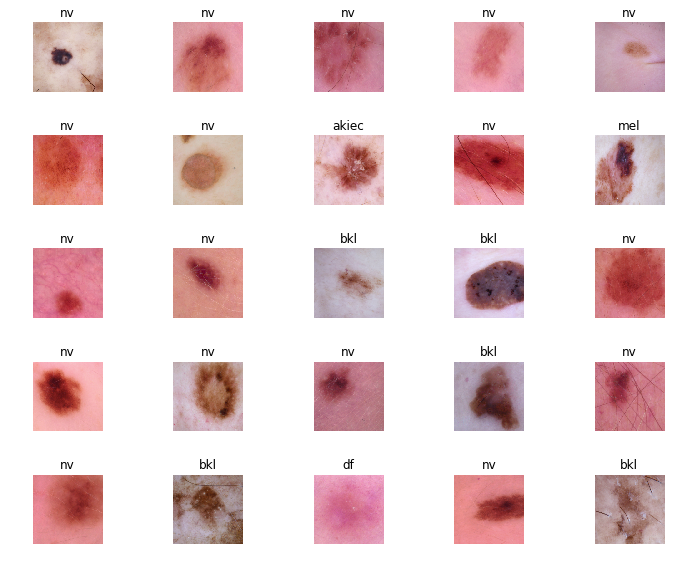

In [5]:
data.show_batch(rows=5, figsize=(10,8))

In [5]:
classes = data.classes
print(classes)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## Learning

#### First 10 epochs on last layer

In [14]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [15]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate
1,1.606062,1.134032,0.297925
2,1.037924,0.682974,0.235178
3,0.759112,0.604944,0.216403
4,0.618512,0.549018,0.193676
5,0.565274,0.543201,0.199605
6,0.513144,0.524587,0.183794
7,0.480780,0.517894,0.183300
8,0.430133,0.494545,0.171443
9,0.412214,0.490321,0.169960
10,0.386438,0.496675,0.169960


In [16]:
learn.save('skin-1')

In [17]:
#learn.load('skin-1')

#### Next 20 epochs on the last 10 layers

In [18]:
learn.unfreeze()
learn.freeze_to(-10)
#learn.lr_find()
#learn.recorder.plot()
learn.fit_one_cycle(20, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,error_rate
1,0.361044,0.494170,0.169960
2,0.368821,0.490524,0.171937
3,0.385142,0.486873,0.169960
4,0.369972,0.479496,0.166008
5,0.360843,0.474560,0.164032
6,0.341519,0.474218,0.163538
7,0.328694,0.478166,0.161561
8,0.312691,0.471638,0.161067
9,0.283102,0.468048,0.157609
10,0.269491,0.464931,0.157115


In [19]:
learn.save('skin-2')

In [20]:
#learn.load('skin-2')

### Confusion matrix on the validation set

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

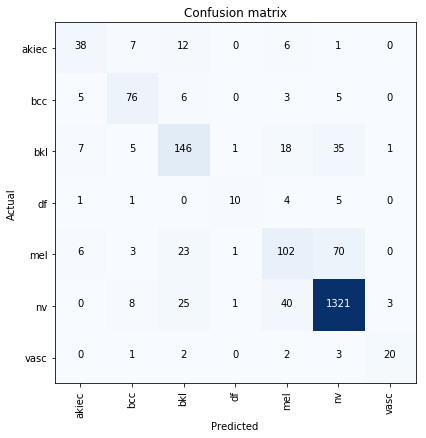

In [22]:
interp.plot_confusion_matrix(figsize=(6,6))

In [23]:
cm = interp.confusion_matrix()
print(pd.DataFrame(cm, columns=[classes], index=[classes]).to_string())

      akiec bcc  bkl  df  mel    nv vasc
akiec    38   7   12   0    6     1    0
bcc       5  76    6   0    3     5    0
bkl       7   5  146   1   18    35    1
df        1   1    0  10    4     5    0
mel       6   3   23   1  102    70    0
nv        0   8   25   1   40  1321    3
vasc      0   1    2   0    2     3   20


#### Confusion matrix for classes with issues, normalizing by row

In [24]:
cm_norm = (cm.T/(cm.sum(axis=1))).T
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

      akiec   bcc   bkl    df   mel    nv  vasc
akiec  0.59  0.11  0.19  0.00  0.09  0.02  0.00
bcc    0.05  0.80  0.06  0.00  0.03  0.05  0.00
bkl    0.03  0.02  0.69  0.00  0.08  0.16  0.00
df     0.05  0.05  0.00  0.48  0.19  0.24  0.00
mel    0.03  0.01  0.11  0.00  0.50  0.34  0.00
nv     0.00  0.01  0.02  0.00  0.03  0.94  0.00
vasc   0.00  0.04  0.07  0.00  0.07  0.11  0.71


#### Confusion matrix for classes with issues, normalizing by column

In [25]:
cm_norm = (cm/(cm.sum(axis=0)))
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

      akiec   bcc   bkl    df   mel    nv  vasc
akiec  0.67  0.07  0.06  0.00  0.03  0.00  0.00
bcc    0.09  0.75  0.03  0.00  0.02  0.00  0.00
bkl    0.12  0.05  0.68  0.08  0.10  0.02  0.04
df     0.02  0.01  0.00  0.77  0.02  0.00  0.00
mel    0.11  0.03  0.11  0.08  0.58  0.05  0.00
nv     0.00  0.08  0.12  0.08  0.23  0.92  0.12
vasc   0.00  0.01  0.01  0.00  0.01  0.00  0.83


## Now predict on the 30% held out (Test set)

In [26]:
src = (ImageItemList.from_folder(path, folder='.', suffix='.jpg') 
       .split_by_folder(train='train', valid='test')
       .label_from_folder())

data = (src.transform(get_transforms(flip_vert=True), size=224, bs=16)
        .databunch().normalize(imagenet_stats))

In [27]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 2962


In [32]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [33]:
learn.load('skin-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5029 items)
[Category bkl, Category bkl, Category bkl, Category bkl, Category bkl]...
Path: /home/jupyter/.fastai/data/skincancer
x: ImageItemList (5029 items)
[Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600)]...
Path: /home/jupyter/.fastai/data/skincancer;

Valid: LabelList
y: CategoryList (2962 items)
[Category bkl, Category bkl, Category bkl, Category bkl, Category bkl]...
Path: /home/jupyter/.fastai/data/skincancer
x: ImageItemList (2962 items)
[Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600)]...
Path: /home/jupyter/.fastai/data/skincancer;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

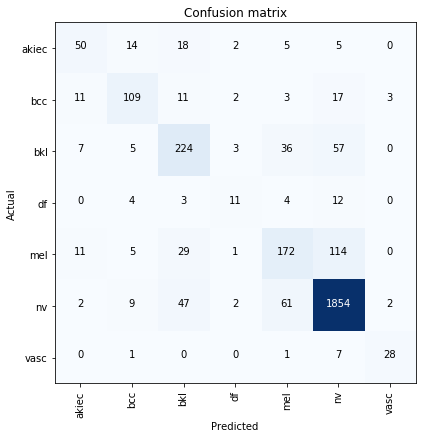

In [35]:
interp.plot_confusion_matrix(figsize=(6,6))

#### Confusion matrix for classes with issues, normalizing by row

In [36]:
cm = interp.confusion_matrix()
cm_norm = (cm.T/(cm.sum(axis=1))).T
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

      akiec   bcc   bkl    df   mel    nv  vasc
akiec  0.53  0.15  0.19  0.02  0.05  0.05  0.00
bcc    0.07  0.70  0.07  0.01  0.02  0.11  0.02
bkl    0.02  0.02  0.67  0.01  0.11  0.17  0.00
df     0.00  0.12  0.09  0.32  0.12  0.35  0.00
mel    0.03  0.02  0.09  0.00  0.52  0.34  0.00
nv     0.00  0.00  0.02  0.00  0.03  0.94  0.00
vasc   0.00  0.03  0.00  0.00  0.03  0.19  0.76


#### Confusion matrix for classes with issues, normalizing by column

In [37]:
cm_norm = (cm/(cm.sum(axis=0)))
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

      akiec   bcc   bkl    df   mel    nv  vasc
akiec  0.62  0.10  0.05  0.10  0.02  0.00  0.00
bcc    0.14  0.74  0.03  0.10  0.01  0.01  0.09
bkl    0.09  0.03  0.67  0.14  0.13  0.03  0.00
df     0.00  0.03  0.01  0.52  0.01  0.01  0.00
mel    0.14  0.03  0.09  0.05  0.61  0.06  0.00
nv     0.02  0.06  0.14  0.10  0.22  0.90  0.06
vasc   0.00  0.01  0.00  0.00  0.00  0.00  0.85
